### Proximal Policy Optimization (PPO) Agent

Proximal Policy Optimization (PPO) is an extension of A2C. The approach is derived from an earlier algorithm Trust Region Policy Optimization (TRPO).

**Trust Region Policy Optimization (TRPO)**

TRPO is a reinforcement learning algorithm designed to improve the stability of policy gradient methods. It addresses the issue of large destabilizing policy updates by imposing the constraint that the new policy does not deviate considerably from the old policy. The central idea is to optimize the policy within a "trust region" which is defined by a constraint on the Kullback-Leibler (KL) divergence between the new policy and old policies:

```math
J(\theta) = \text{max}_\theta \ \mathbb{E}_{\tau \sim \pi_{\text{old}}} \left[\sum_{t=0}^T \text{log} \pi_\theta(a_t \mid s_t) \cdot A(s_t, a_t)\right]
```

Where

```math
\mathbb{E}_{\tau \sim \pi_{\text{old}}} \left[\text{KL} \left[\pi_{\text{old}}(a_t \mid s_t) \| \pi_\theta(a_t \mid s_t)\right]\right] \leq \delta
```

Here, $\delta$ is a small constant that controls the size of the trust region.

**Proximal Policy Optimization (PPO)**

PPO simplifies TRPO by imposing the constraint that the new policy does not deviate considerably from the old policy without the need for complex optimization constraints. PPO uses a surrogate objective function that incorporates a clipping mechanism to limit the size of policy updates:

```math
\mathcal{L}(\theta) = \mathbb{E}_{t} \left[ \text{min} \left( r_t(\theta) \cdot A_t, \ \text{clip} \left(r_t(\theta), 1 - \epsilon, 1 + \epsilon \right) \cdot A_t \right) \right]
```

Where

```math
r_t(\theta) = \frac{\pi_\theta(a_t \mid s_t)}{\pi_{\text{old}}(a_t \mid s_t)}
```

Here, $\epsilon$ is a small constant that controls the clipping range.

In the following implementation, this is computed in `Agent.learn`:

```python
surr1 = ratios * advantages
surr2 = torch.clamp(ratios, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * advantages
policy_loss = -torch.min(surr1, surr2).mean()
```

In practice, `Agent.k_epochs` refer to the number of times the algorithm updates its policy with the same batch of data. This approach helps to make efficient use of collected data and stabilizes training by refining the policy through repeated optimization while avoiding drastic updates.

---
The full implementation is below.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_1_dim=128, n_hidden_2_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        self.fc3 = nn.Linear(n_hidden_2_dim, n_action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class ValueNetwork(nn.Module):
    def __init__(self, n_obs_dim: int, n_hidden_1_dim=128, n_hidden_2_dim=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        self.fc3 = nn.Linear(n_hidden_2_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [2]:
from torch.distributions import Categorical
import numpy as np

class Agent:
    
    def __init__(self, obs_space: int, act_space: int, alpha=1e-4, gamma=0.99, lambda_GAE=0.95, clip_epsilon=0.18, k_epochs=6, entropy_regularization_coefficient=1e-2):
        
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_GAE = lambda_GAE 
        self.clip_epsilon = clip_epsilon
        self.k_epochs = k_epochs

        self.entropy_regularization_coefficient = entropy_regularization_coefficient

        self.policy = PolicyNetwork(obs_space, act_space)
        self.value = ValueNetwork(obs_space)

        self.optimizer_policy = torch.optim.AdamW(self.policy.parameters(), lr=self.alpha)
        self.optimizer_value = torch.optim.AdamW(self.value.parameters(), lr=self.alpha)

        self.eps = np.finfo(np.float32).eps.item()

    def act(self, state: np.ndarray) -> tuple[int, torch.Tensor, torch.Tensor]:
        state = torch.from_numpy(state).float().unsqueeze(0)
        dist = Categorical(self.policy(state))
        action = dist.sample() 
        return action.item(), dist.log_prob(action), dist.entropy()

    def compute_td_error(self, rewards, values):
        deltas = rewards + self.gamma * torch.cat([values[1:], torch.zeros(1)]) - values
        return deltas

    def compute_gae_advantages(self, deltas):
        advantage = 0
        advantages = torch.zeros_like(deltas)
        for t in reversed(range(len(deltas))):
            advantage = deltas[t] + self.gamma * self.lambda_GAE * advantage
            advantages[t] = advantage
        return advantages
    
    def learn(self, states: list[np.ndarray], actions: list[int], rewards: list[float], next_states: list[np.ndarray], dones: list[bool], old_log_probs: torch.Tensor) -> float:
        
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32)

        rewards = (rewards - rewards.mean()) / (rewards.std() + self.eps)

        with torch.no_grad():
            V_targets_next = self.value(next_states).squeeze()
            V_targets = rewards + (1 - dones) * self.gamma * V_targets_next
            V_predicted = self.value(states).squeeze()

        deltas = self.compute_td_error(rewards, V_predicted)
        advantages = self.compute_gae_advantages(deltas)

        for _ in range(self.k_epochs):
            dist = Categorical(self.policy(states))
            log_probs = dist.log_prob(actions)
            ratios = torch.exp(log_probs - old_log_probs.detach())

            # PPO clipped objective
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(self.value(states).squeeze(), V_targets)

            entropy_loss = dist.entropy().mean()
            policy_loss -= self.entropy_regularization_coefficient * entropy_loss

            self.optimizer_policy.zero_grad()
            policy_loss.backward()
            self.optimizer_policy.step()

            self.optimizer_value.zero_grad()
            value_loss.backward()
            self.optimizer_value.step()

        return policy_loss.item()

In [3]:
import gymnasium as gym

env = gym.make('LunarLander-v2', render_mode='rgb_array')
obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

print(f'LunarLander-v2 Environment')
print(f' Observation Space:', obs_space)
print(f' Action Space:', act_space)

LunarLander-v2 Environment
 Observation Space: 8
 Action Space: 4


In [4]:
from gymnasium.vector import SyncVectorEnv
import imageio

agent = Agent(obs_space, act_space)

n_envs = 5
env_fns = [lambda: env] + [lambda: gym.make("LunarLander-v2") for _ in range(n_envs-1)]
envs = SyncVectorEnv(env_fns)

n_average = 10
loss_hist = []
reward_hist = []

frames = []

n_trajectories = 1500 // n_envs
for i in range(n_trajectories + 1):

    states = envs.reset()[0]
    
    env_states = []
    env_actions = []
    env_rewards = []
    env_next_states = []
    env_dones = []
    old_log_probs = []

    total_rewards = np.zeros(n_envs)
    done = np.zeros(n_envs, dtype=bool)

    T = 1000
    for t in range(T):

        if i % (n_average * 2.5) == 0:
            frame = env.render()
            frames.append(frame)
        
        actions = []
        log_probs = []
        for state in states:
            action, log_prob, _ = agent.act(state)
            actions.append(action)
            log_probs.append(log_prob)

        next_states, rewards, terminated, truncated, _ = envs.step(actions)
        done = done | terminated | truncated
        
        for j in range(n_envs):

            if not done[j]:
                env_states.append(states[j])
                env_actions.append(actions[j])
                env_rewards.append(rewards[j])
                env_next_states.append(next_states[j])
                env_dones.append(done[j])
                old_log_probs.append(log_probs[j])

                total_rewards[j] += rewards[j]
        
        states = next_states

        if np.all(done):
            break

    env_states = np.array(env_states)
    env_actions = np.array(env_actions)
    env_rewards = np.array(env_rewards)
    env_next_states = np.array(env_next_states)
    env_dones = np.array(env_dones)
    old_log_probs = torch.cat(old_log_probs)

    loss = agent.learn(env_states, env_actions, env_rewards, env_next_states, env_dones, old_log_probs)
    
    reward_hist.append(total_rewards.mean())
    loss_hist.append(loss)

    if i % n_average == 0:
        avg_loss = np.mean(loss_hist[max(0, i-n_average):(i+1)])
        avg_reward = np.mean(reward_hist[max(0, i-n_average):(i+1)])
        print(f"Episode: {i}/{n_trajectories} | Average Reward: {avg_reward:3.4f} | Average Loss: {avg_loss:3.4f}")

Episode: 0/300 | Average Reward: -167.4336 | Average Loss: 0.0424
Episode: 10/300 | Average Reward: -91.3617 | Average Loss: 0.0161
Episode: 20/300 | Average Reward: -51.3130 | Average Loss: -0.0176
Episode: 30/300 | Average Reward: -61.6576 | Average Loss: -0.0880
Episode: 40/300 | Average Reward: -60.6671 | Average Loss: -0.0754
Episode: 50/300 | Average Reward: -83.6235 | Average Loss: -0.0423
Episode: 60/300 | Average Reward: -83.2763 | Average Loss: -0.0527
Episode: 70/300 | Average Reward: -84.5147 | Average Loss: -0.0633
Episode: 80/300 | Average Reward: -67.9819 | Average Loss: -0.0863
Episode: 90/300 | Average Reward: -65.0163 | Average Loss: -0.0977
Episode: 100/300 | Average Reward: -51.1257 | Average Loss: -0.1043
Episode: 110/300 | Average Reward: -47.1403 | Average Loss: -0.1032
Episode: 120/300 | Average Reward: -45.7782 | Average Loss: -0.0792
Episode: 130/300 | Average Reward: -44.3285 | Average Loss: -0.1226
Episode: 140/300 | Average Reward: -26.4233 | Average Loss: 

In [5]:
torch.save(agent.policy.state_dict(), 'PPO.pth')

In [6]:
imageio.mimsave('./GIF/PPO.GIF', frames, fps=45)

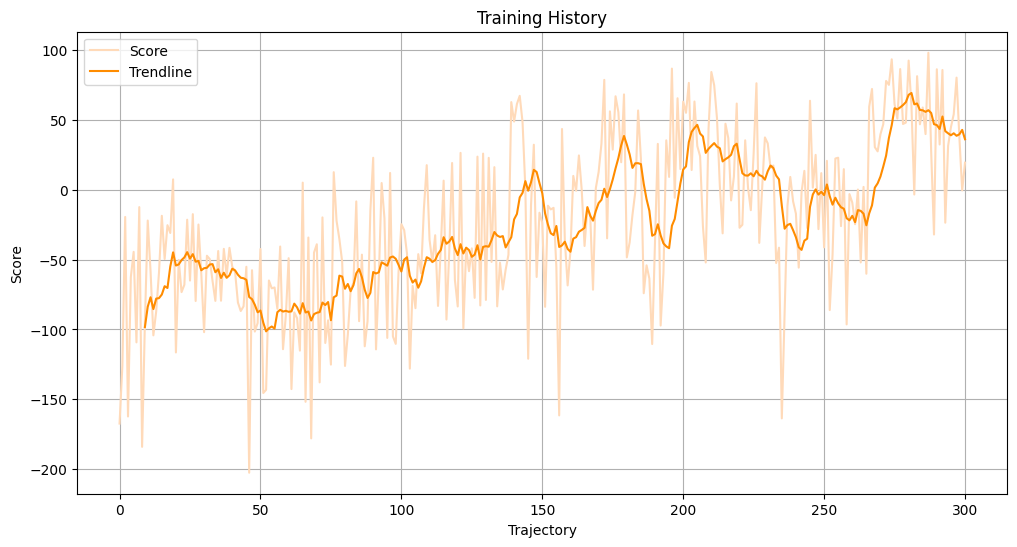

In [7]:
import matplotlib.pyplot as plt

trendline = np.convolve(reward_hist, np.ones(n_average)/n_average, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(reward_hist, label='Score', color='#FFDAB9')
plt.plot(range(n_average-1, len(reward_hist)), trendline, label='Trendline', color='#FF8C00')
plt.title('Training History')
plt.xlabel('Trajectory')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()